In [18]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import shapely.geometry
import numpy as np
import json
from affine import Affine
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
import pandas as pd
from scipy.ndimage import gaussian_filter
import seaborn as sns
from scipy.signal import find_peaks

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
sns.set_style("ticks")

plt.rcParams.update({
    "axes.titlesize": 24,            # Title font size
    "axes.labelpad": 10,             # Padding for the x and y labels
    "axes.labelcolor" : "dimgray",
    "xtick.labelsize": 16,           # Font size for the x tick labels
    "ytick.labelsize": 16,           # Font size for the y tick labels
    "axes.labelsize": 20,            # Font size for the x and y axis labels
    "font.family": "Arial",          # Set the font family to Arial
    "grid.linestyle": "--",          # Set the style of the gridlines
    "grid.linewidth": 0.5,           # Set the width of the gridlines
    "grid.color": "gray",            # Set the color of the gridlines
    "axes.grid": True,               # Enable the grid
    "axes.grid.which": "both",       # Apply the grid to both major and minor ticks
    "xtick.direction": "in",         # Set the direction of the x tick marks
    "ytick.direction": "in",         # Set the direction of the y tick marks
    "xtick.major.size": 6,           # Set the length of the major x tick marks
    "xtick.major.width": 2,          # Set the width of the major x tick marks
    "ytick.major.size": 6,           # Set the length of the major y tick marks
    "ytick.major.width": 2,          # Set the width of the major y tick marks
    "xtick.color": "gray",           # Color of x tick labels and tick lines
    "ytick.color": "gray"            # Color of y tick labels and tick lines
})

In [19]:
# bbox_geojson for the CedarLakes AOI


# bbox_geojson = {
#     "type": "Polygon",
#     "coordinates": [
#         [
#             [-95.514107383931105, 28.837294991608498],
#             [-95.542191067157702, 28.82310160914],
#             [-95.533023536824004, 28.807894014576299],
#             [-95.5039012207138, 28.822751403692301],
#             [-95.514107383931105, 28.837294991608498],
#         ]
#     ],
# }


# bbox_geojson for the CedarLakes Dune Part AOI
bbox_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [-95.506891, 28.826835],
            [-95.503908, 28.822756],
            [-95.53272, 28.80838],
            [-95.535127, 28.812163],
            [-95.506891, 28.826835],
        ]
    ],
}

# bbox_geojson ={
#     "type": "Polygon",
#     "coordinates": [
#         [
#             [-95.509043, 28.829857],
#             [-95.537833, 28.815298],
#             [-95.533024, 28.807894],
#             [-95.503901, 28.822751],
#             [-95.509043, 28.829857]
#         ]
#     ],
# }




In [20]:
def clip_raster(filepath, bbox_geojson):
    bbox_geom = gpd.GeoDataFrame.from_features(
        [{"type": "Feature", "properties": {}, "geometry": bbox_geojson}],
        crs="EPSG:4326",
    )
    with rasterio.open(filepath) as src:
        src_crs = src.crs if src.crs else "EPSG:4326"
        bbox_geom = bbox_geom.to_crs(crs=src_crs)
        intersection = bbox_geom.unary_union.intersection(
            shapely.geometry.box(*src.bounds)
        )
        if not intersection.is_empty:
            out_image, out_transform = mask(src, shapes=[intersection], crop=True)
            out_image[out_image < -1000] = np.nan
            out_meta = src.meta.copy()
            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "nodata": np.nan,
                }
            )

            return out_image, out_transform, out_meta
    return None, None, None


In [21]:
def rotate_image(
    image, transform, meta, angle, shift_x=0, shift_y=0, adj_width=0, adj_height=0
):

    src_transform = transform
    rotate = Affine.rotation(angle)
    trans_x = Affine.translation(shift_x, 0)
    trans_y = Affine.translation(0, -shift_y)
    dst_transform = src_transform * rotate * trans_x * trans_y

    y, x = image.shape[1:]
    dst_height = int(y + adj_height)
    dst_width = int(x + adj_width)

    dst_image = np.empty(
        shape=(image.shape[0], dst_height, dst_width), dtype=image.dtype
    )

    meta.update(
        {
            "transform": dst_transform,
            "height": dst_height,
            "width": dst_width,
            "nodata": np.nan,
        }
    )

    reproject(
        source=image,
        destination=dst_image,
        src_transform=src_transform,
        dst_transform=dst_transform,
        src_crs=meta["crs"],
        dst_crs=meta["crs"],
        resampling=Resampling.nearest,
        src_nodata=meta.get("nodata"),
        dst_nodata=np.nan,
    )

    # Find the bounding box where data exists
    valid_data_positions = np.where(~np.isnan(dst_image))
    ymin, xmin = valid_data_positions[1].min(), valid_data_positions[2].min()
    ymax, xmax = valid_data_positions[1].max(), valid_data_positions[2].max()

    # Clip the image to the bounding box
    dst_image_clipped = dst_image[:, ymin : ymax + 1, xmin : xmax + 1]
    plt.imshow(dst_image_clipped[0], cmap="gray")
    plt.title("Rotated and Clipped Image")
    plt.show()

    # Update metadata for the clipped image
    new_height, new_width = dst_image_clipped.shape[1], dst_image_clipped.shape[2]
    new_transform = dst_transform * Affine.translation(xmin, ymin)
    meta.update(
        {
            "transform": new_transform,
            "height": new_height,
            "width": new_width,
        }
    )

    return dst_image_clipped, new_transform, meta


In [22]:
def apply_gaussian_filter(elevation, sigma=2):
    return gaussian_filter(elevation, sigma=sigma)


In [23]:
def find_zero_crossings(elevation_threshold):
    crossing_indices = np.where(np.diff(np.sign(elevation_threshold)))[0]
    return crossing_indices


In [24]:
def calculate_average_dune_slope(elevation, crossShoreDistance, threshold):

    crossing_indices = find_zero_crossings(elevation - threshold)
    max_elevation_index = np.argmax(elevation)
    duneHeight = calculate_dune_height(elevation)

    if max_elevation_index == 0:
        return np.nan
    if crossing_indices.size > 0 and crossing_indices[0] < max_elevation_index:
        before_max_index = crossing_indices[crossing_indices < max_elevation_index][-1]
    else:
        return np.nan

    elevation_at_before_max = elevation[before_max_index]
    horizontal_distance = (
        crossShoreDistance[max_elevation_index] - crossShoreDistance[before_max_index]
    )

    average_slope = (duneHeight - elevation_at_before_max) / horizontal_distance
    return average_slope


In [25]:
def calculate_smoothed_average_dune_slope(
    gaussian_elevation, argmax_val, zero_crossings, pixel_width
):
    if argmax_val == 0:
        return np.nan
    if zero_crossings.size > 0 and zero_crossings[0] < argmax_val:
        before_argmax = zero_crossings[zero_crossings < argmax_val][-1]
    else:
        before_argmax = 0

    duneHeight = calculate_dune_height(gaussian_elevation)
    elevation_at_before_argmax = gaussian_elevation[before_argmax]
    horizontal_distance = (argmax_val - before_argmax) * pixel_width
    average_slope = (duneHeight - elevation_at_before_argmax) / horizontal_distance
    return average_slope


In [26]:
def plot_dune_characteristics(
    crossShoreDistance, elevation, gaussian_elevation, threshold
):

    crossing_indices = find_zero_crossings(elevation - threshold)
    max_elevation_index = np.argmax(elevation)

    peaks, valleys = find_dune_extrema(elevation)

    plt.figure()
    plt.plot(crossShoreDistance, elevation, label="Original")
    # plt.plot(crossShoreDistance[peaks], elevation[peaks], "r.", label="Maxima")
    # plt.plot(crossShoreDistance[valleys], elevation[valleys], "g.", label="Minima")

    plt.scatter(
        crossShoreDistance[max_elevation_index],
        elevation[max_elevation_index],
        color="black",
        s=10,
        label="Max Elevation",
    )
    plt.scatter(
        crossShoreDistance[crossing_indices],
        elevation[crossing_indices],
        color="green",
        s=10,
        label="Crossing Indices",
    )
    plt.legend()
    plt.minorticks_on()
    plt.grid(which="major", linestyle="-", linewidth="0.5", color="gray")
    plt.grid(which="minor", linestyle=":", linewidth="0.5", color="gray")
    plt.tick_params(which="minor", length=4, color="red")
    plt.show()


In [27]:




def calculate_max_dune_slope(elevation, crossShoreDistance):
    max_elevation_index = np.argmax(elevation)
    if max_elevation_index == 0:
        return np.nan
    elev_diff = np.diff(elevation[: max_elevation_index + 1])
    dist_diff = np.diff(crossShoreDistance[: max_elevation_index + 1])
    max_slope = np.nanmax(elev_diff / dist_diff)
    return max_slope




def calculate_dune_height(elevation):
    duneHeight = np.nanmax(elevation)
    return duneHeight

def find_dune_extrema(elevation):
    peaks, _ = find_peaks(elevation)
    return peaks, _

def calculate_primary_dune(elevation):
    peaks, _ = find_dune_extrema(elevation)
    peaks_above_threshold = [peak for peak in peaks if elevation[peak] > 1.5]
    if not peaks_above_threshold:
        return np.nan
    primaryDuneHeight = elevation[peaks_above_threshold[0]]
    return primaryDuneHeight



def calculate_dune_characteristics(elevation, crossShoreDistance, threshold):
    # smoothed_elevation = apply_gaussian_filter(elevation, sigma=1)
    crossing_indices = find_zero_crossings(elevation - threshold)
    dunes_info = []

    for i in range(len(crossing_indices) - 1):
        left_index = crossing_indices[i]
        right_index = crossing_indices[i + 1]
        dune_segment = elevation[left_index : right_index + 1]
        if dune_segment[1] > threshold:

            dune_width = (
                crossShoreDistance[right_index] - crossShoreDistance[left_index]
            )

            dune_height = calculate_dune_height(elevation[left_index:right_index])
            if dune_height < threshold:
                dune_height = threshold
            max_slope = calculate_max_dune_slope(
                elevation[left_index:right_index],
                crossShoreDistance[left_index : right_index + 1],
            )

            aspect_ratio = (dune_height - threshold) / dune_width
            dune_info = {
                "dune_width": round(float(dune_width), 1),
                "dune_height": round(float(dune_height), 2),
                "aspect_ratio": round(float(aspect_ratio), 3),
                "max_slope":round(float(max_slope), 2) if not np.isnan(max_slope) else None,
            }
            if i > 0:
                distance_to_previous = (
                    crossShoreDistance[left_index]
                    - crossShoreDistance[crossing_indices[i - 1]]
                )
                dune_info["distance_to_previous_dune"] = round(float(distance_to_previous), 1)
            dunes_info.append(dune_info)

    return dunes_info


In [28]:
def find_dune_extrema(elevation):
    peaks, _ = find_peaks(elevation)
    valleys, _ = find_peaks(-elevation)
    return peaks, valleys


In [29]:
def calculate_island_width(elevation, crossShoreDistance, threshold):
    # smoothed_elevation = apply_gaussian_filter(elevation, sigma=1)
    crossing_indices = find_zero_crossings(elevation - threshold)

    if len(crossing_indices) < 2:
        return np.nan

    left_index = crossing_indices[0]
    right_index = crossing_indices[1]
    if elevation[0] > threshold:
        return np.nan

    island_width = crossShoreDistance[right_index] - crossShoreDistance[left_index]
    return island_width  # Return the width of the first section above the


In [30]:

NAVD88toMSL = -0.09 # meters

def analyze_raster(image, transform, output_csv_path, dem_year):

    band1 = image[0]
    band1 = band1 + NAVD88toMSL
    band1 = np.flipud(band1)
    pixel_width = transform[0]
    print(f"Pixel Width: {pixel_width:.4f}")
    sigma = 5
    island_threshold = 1.0
    dune_treshold = 1.5

    island_width = []
    alongshore = []
    max_elevation_crossshore = []
    all_dunes_info = []
    primary_dune_height_crossshore = []
    max_dune_slope_crossshore = []
    
    for i in range(band1.shape[1]):
        try:
            alongshoreDistance = i * pixel_width
            elevation = band1[:, i]
            elevation = elevation[~np.isnan(elevation)]
            crossShoreDistance = np.arange(0, len(elevation) * pixel_width, pixel_width)
            gaussian_elevation = apply_gaussian_filter(elevation, sigma=sigma)
            islandWidth = calculate_island_width(
                elevation, crossShoreDistance, island_threshold
            )
            max_elevation = float(calculate_dune_height(elevation))
            if max_elevation < 0:
                max_elevation = 0
            primary_dune_height = calculate_primary_dune(elevation)
            max_dune_slope = calculate_max_dune_slope(elevation, crossShoreDistance)
            dunes_info = calculate_dune_characteristics(
                elevation, crossShoreDistance, dune_treshold
            )
            if dunes_info:  # if there are dunes in this cross section
                all_dunes_info.append(
                    {
                        "cross_section": i,
                        "alongshoreDistance": round(alongshoreDistance, 1),
                        "max_elevation": round(max_elevation, 2),
                        "dunes": dunes_info,
                    }
                )

            island_width.append(islandWidth)
            alongshore.append(i * pixel_width)
            max_elevation_crossshore.append(max_elevation)
            primary_dune_height_crossshore.append(primary_dune_height)
            max_dune_slope_crossshore.append(max_dune_slope)


            if False:
                if i < 10:
                    # if i == 203:
                    print(
                        f"i = {i},"
                        f"alongshoreDistance:{alongshoreDistance:.1f}, "
                        f"islandWidth:{islandWidth:.1f}, "
                    )

                    plot_dune_characteristics(
                        crossShoreDistance,
                        elevation,
                        gaussian_elevation,
                        island_threshold,
                    )

        except Exception as e:
            # print(f"Error is: {e}")
            pass

    df = pd.DataFrame(
        {
            "alongshore": alongshore,
            "islandWidth": island_width,
            "maxElevation": max_elevation_crossshore,
            "primaryDuneHeight": primary_dune_height_crossshore,
            "maxDuneSlope": max_dune_slope_crossshore,
            "DEM": dem_year,
        }
    )
    df = df.round(3)
    output_csv_path = f"Results/DuneFeatures_Width_Height_Slope/Data/{output_csv_path}"
    with open(output_csv_path.replace("csv", "json"), "w") as outfile:
        json.dump(all_dunes_info, outfile, indent=4)
    print(dem_year)
    df.to_csv(output_csv_path, index=False)


In [31]:

rasters_dict = {
    "Clipped(2001)_meter.tif": "DEM 2001",
    "Clipped(2002)_meter.tif": "DEM 2002",
    # "Clipped(2006)_meter.tif": "DEM 2006",
    "Clipped(2009)_meter.tif": "DEM 2009",
    # "Clipped(2016)_meter.tif": "DEM 2016",
    "Clipped(2018)_meter.tif": "DEM 2018",
    "(Clipped)2018_19_post_harvey_meter.tif": "DEM 2018_19_post_harvey",
}


In [32]:

# rasters_dict = {
#     "Clipped(2001)_meter.tif": "DEM 2001",
# }


In [33]:
def process_raster(
    filepath,
    bbox_geojson,
    angle,
    shift_x,
    shift_y,
    adj_width,
    adj_height,
    output_geojson_path,
    dem_year,
):
    image, transform, meta = clip_raster(filepath, bbox_geojson)
    if image is not None:
        image, transform, meta = rotate_image(
            image, transform, meta, angle, shift_x, shift_y, adj_width, adj_height
        )
        analyze_raster(image, transform, output_geojson_path, dem_year=dem_year)


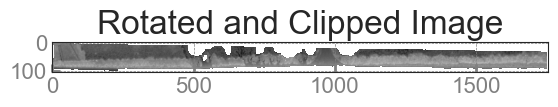

Pixel Width: 1.5172
DEM 2001


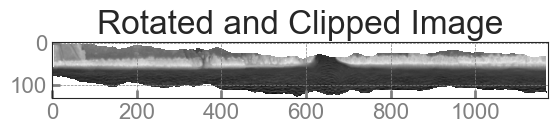

Pixel Width: 2.2758
DEM 2002


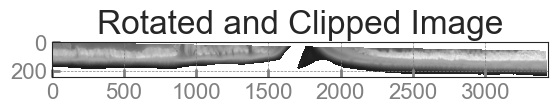

Pixel Width: 0.7586
DEM 2009


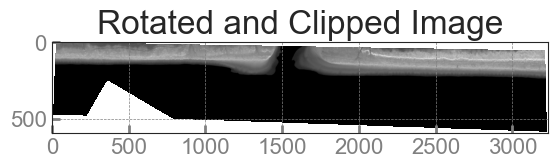

Pixel Width: 0.8294
DEM 2018


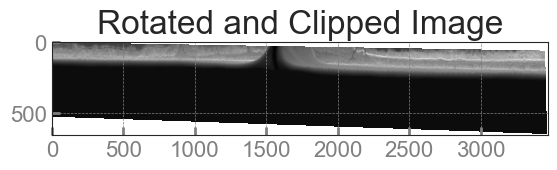

Pixel Width: 0.7507
DEM 2018_19_post_harvey


In [34]:
for in_file, dem_year in rasters_dict.items():
    output_csv_path = f"duneCharacteristics_{dem_year.replace(' ', '_')}.csv"
    process_raster(
        in_file,
        bbox_geojson,
        angle=-34,
        shift_x=-1000,
        shift_y=0,
        adj_width=2000,
        adj_height=500,
        output_geojson_path=output_csv_path,
        dem_year=dem_year,
    )
